# Animal Shelter (Separate cat/dog classifiers)


In [326]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Load the Animal Shelter dataset and display a sample.

In [327]:
df = pd.read_csv("train.csv")

In [328]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [329]:
df.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


# 1. Data Preparation


Split the "SexuponOutcome" field into "Sex" and "Neutered".

In [330]:
def splitSex(df):
    df.loc[df["SexuponOutcome"].isnull(), "SexuponOutcome"]="unknown"

    df["Sex"] = df["SexuponOutcome"].str.lower().str.contains(" male")
    df.loc[df["SexuponOutcome"].str.lower().str.contains(" male"), "Sex"] = "male"
    df.loc[df["SexuponOutcome"].str.lower().str.contains("female"), "Sex"] = "female"
    df.loc[df["SexuponOutcome"].str.lower().str.contains("unknown"), "Sex"] = "unknown"

    df["Neutered"] = (df["SexuponOutcome"].str.lower().str.contains("neutered")) |  (df["SexuponOutcome"].str.lower().str.contains("spayed"))
    df["Neutered"] = df["Neutered"].astype(int)
    df[["SexuponOutcome", "Sex", "Neutered"]].head()
    
splitSex(df)

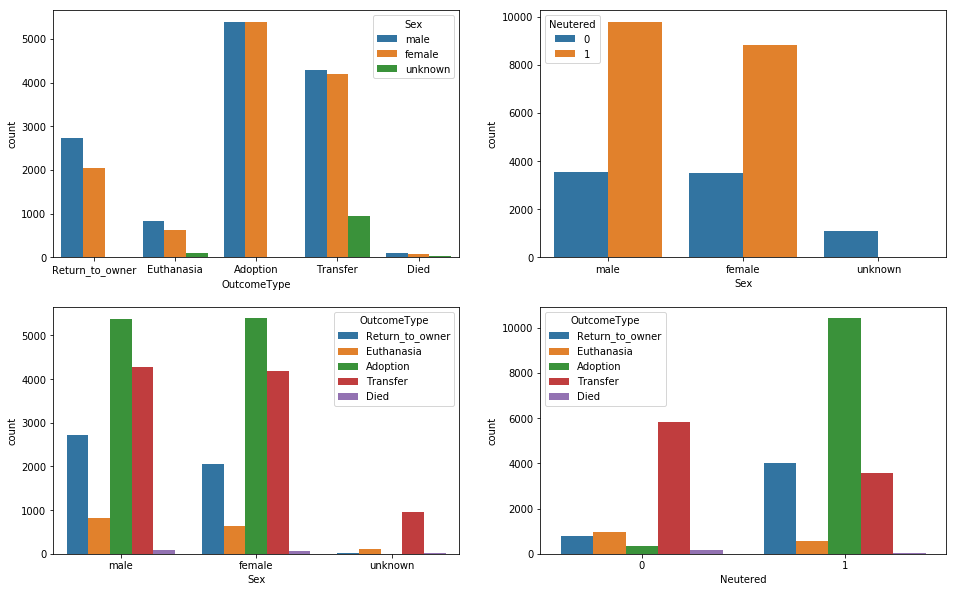

In [331]:
f, ([ax1, ax3], [ax2, ax4]) = plt.subplots(2, 2, figsize=(16, 10))
sns.countplot(data=df, x='OutcomeType',hue='Sex', ax=ax1)
sns.countplot(data=df, x='Sex',hue='OutcomeType', ax=ax2)
sns.countplot(data=df, x="Sex", hue="Neutered", ax=ax3)
sns.countplot(data=df, x="Neutered", hue="OutcomeType", ax=ax4)

Clean up breed

In [332]:
def cleanupBreed(df):
    df["PureBreed"] = ~df["Breed"].str.lower().str.contains("mix")
    df.loc[df["Breed"].str.contains("/"), "PureBreed"]=False
    df["PureBreed"] = df["PureBreed"].astype(int)
    df[["Breed", "PureBreed"]].head(10)
    
cleanupBreed(df)

Plot normalized ratios of outcomes by breed purity. Purebreed dogs are more likely to be returned to owner (not surprising), however not more likely to be adopted(surprising).

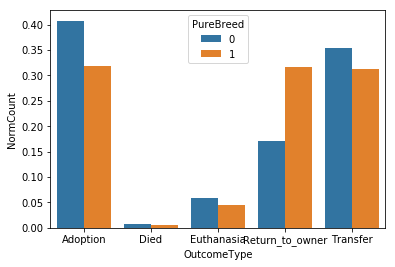

In [333]:
def normalizeCounts(df, x, sub_x, local_agg=False):

    agg1 = df.pivot_table(index=[x, sub_x], values=["AnimalID"], aggfunc=len)

    agg1.columns=["NormCount"]
    agg1["NormCount"] = agg1["NormCount"].astype(float)
    agg2 = df.pivot_table(index=[sub_x], values="AnimalID", aggfunc=len)
    #print agg2
    
    x_vals = agg1.index.levels[0].values
    
    #print agg1
    for x_val in x_vals:
        sub_x_vals = agg1.loc[x_val].index.unique().values
        if local_agg:
            tot = sum(agg1.loc[x_val, "NormCount"].values)
        
            
        for sub_x_val in sub_x_vals:
            if not local_agg:
                tot = agg2.loc[sub_x_val][0]
        
            val = agg1.loc[x_val].loc[sub_x_val,"NormCount"]
            val /= tot
            agg1.loc[x_val].loc[sub_x_val]=val


    agg1 = agg1.reset_index()
    #print agg1
    
    return agg1

sns.barplot(data=normalizeCounts(df, "OutcomeType", "PureBreed"), x="OutcomeType", hue="PureBreed", y="NormCount")
#sns.countplot(data=df, x="OutcomeType", hue="PureBreed")

Dog breed dataset collated from http://www.dogsindepth.com/dog_breed_size_chart.html.

Dogs breeds are classified according to size from 1 (smallest) to 8 (largest)

In [334]:
breedsdf = pd.read_csv("breeds.csv")
breedsdf.head(20)

,Breed,Size
0,chihuahua,1
1,Affenpinscher,2
2,Cairn Terrier,2
3,German Spitz,2
4,Spitz,2
5,Kleinspitz,2
6,Havanese,2
7,Japanese Chin,2
8,Maltese,2
9,Norfolk Terrier,2


Train a NB classifier in an attempt to estimate dog size by breed. 

In the case of mixes, the Naive Bayes classifier should give us an probable estimate based on the constituent breeds.

This will never be exact, but it should give us a useful indication.

N.B. We do not calculate accuracy for this classifier because there is no repeated information in the data set, so it does not make sense to split it into training and test sets. The Naive Bayes classifier here should be simply understood as a convenient way of matching breed names and combining breeds in the case of a mix. Visual inspection indicates that the results are quite satisfactory.

In [335]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

def preprocessBreed(df):
    vec = CountVectorizer()
    
    breedsTDM = vec.fit_transform(df["Breed"].str.replace("Mix", "").str.replace("/", " ").str.lower())
    print breedsTDM.shape
    print breedsTDM.toarray()
    
    return breedsTDM
    
def processBreed(df, breedsTDM):
    breedsdf = pd.DataFrame(breedsTDM.toarray())
    breedCols = ["Breed_"+str(i) for i in range(0, breedsTDM.shape[1]) ]
    breedsdf.columns = breedCols
    #print breedsdf.head()

    df = df.join(breedsdf)
    #print df.head()
    return df

breedsTDM = preprocessBreed(df)
df = processBreed(df, breedsTDM)
df.head()

(26729, 261)
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Breed_251,Breed_252,Breed_253,Breed_254,Breed_255,Breed_256,Breed_257,Breed_258,Breed_259,Breed_260
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,...,0,0,0,0,0,0,0,0,0,0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,...,0,0,0,0,0,0,0,0,0,0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,...,0,0,0,0,0,0,0,0,0,0
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,...,0,0,0,0,0,0,0,0,0,0
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,...,0,0,0,0,0,0,0,0,0,0


from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

vec = CountVectorizer()
knownBreedsTDM = vec.fit_transform(breedsdf.loc[:,"Breed"])

#pca = PCA()
#reduced_dims = pca.fit_transform(knownBreedsTDM.toarray())



breedsClf = GaussianNB()
breedsClf.fit(knownBreedsTDM.toarray(), breedsdf.loc[:, "Size"])
print knownBreedsTDM.shape

Generate size estimates for our animals...cats are very uniformly sized and we set them to size 1.

Plot a size distribution of dogs. We seem to have a majority of medium sized dogs and very few very big ones. This is as expected for a standard animal shelter. 

Explore outcomes by size. Interesting that the very large dogs seem to have smaller odds of being adopted. Small dogs are, however the most likely to be adopted. This is also not surprising. Also medium/large dogs (size 5) are by far the most likely to be euthanized.

Plot of the same data, but unnormalized. 

We define a function that translates the age fields in the dataset to days by parsing the units (year(s), month(s), week(s)). We then map the age in days to an ageBracket field so as to categories the animals as (BABY, ADULT, SENIOR). 

In [336]:
def getAgeInDays(ageStr):
    if pd.isnull(ageStr):
        return ageStr
    
    ageParts = ageStr.lower().split(" ")
    val = int(ageParts[0])
    units = ageParts[1]
    
    if units[-1:]=="s":
        units = units[0:-1]
    
    if units=="year":
        val = 365*val
    elif units=="month":
        val = 30*val
    elif units=="week":
        val = 7*val
    
    return val

def getAgeBracket(ageInDays):
    if ageInDays<=42:
        return "baby"
    elif ageInDays<=365:
        return "juvinile"
    elif ageInDays<=365*9:
        return "adult"
    else:
        return "senior"

    
def processAge(df):
    df["AgeDays"] = df["AgeuponOutcome"].apply(getAgeInDays)
    meanAge = df[["AgeDays"]].mean()

    df.loc[df["AgeDays"].isnull(), "AgeDays"]=meanAge[0]
    df["AgeBracket"] = df["AgeDays"].apply(getAgeBracket)
    
    
processAge(df)


A quick histogram of age distribution shows that most animals at the shelter are younger than about 2 years of age.

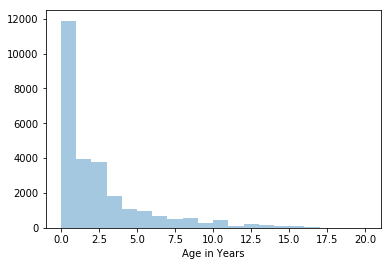

In [337]:

sns.distplot(df.AgeDays/365, bins = 20, kde=False, axlabel="Age in Years")

Visualising outcomes based on these age categories reveals, unsurprisingly, that babies are more likely to be adopted (or transferred) than any other age bracket. Sadly the data also reveals that babies are the most likely to die at the shelter.

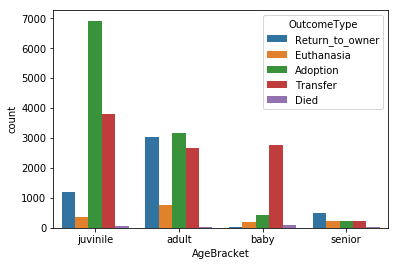

In [338]:


sns.countplot(data=df, x="AgeBracket", hue="OutcomeType")

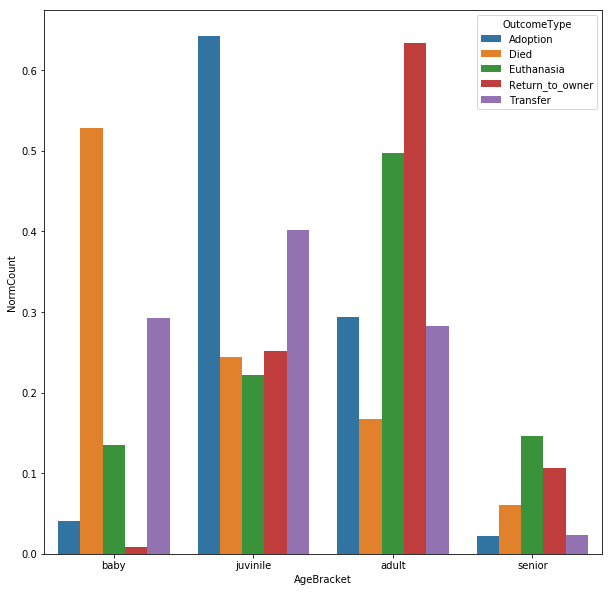

In [339]:
# Generate distribution of dog sizes grouped by outcome, normalized over outcome.
f, ax1 = plt.subplots(1, 1, figsize=(10, 10))
sns.barplot(data=normalizeCounts(df, "AgeBracket", "OutcomeType"), x="AgeBracket", hue="OutcomeType", y="NormCount", order=["baby", "juvinile", "adult", "senior"])



Here we also take the DateTime column and we categorize split the day into 3 hour segments. This should tell us the most likely time of day for an outcome. It looks like most adoptions as well as most transfers occur during the afternoon and early evening, peaking around 15:00.

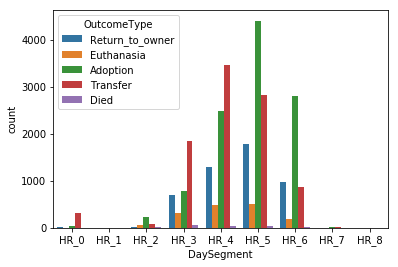

In [340]:
def tsToDaySegment(ts):
    return "HR_"+str(int(ts.hour/3))
    
def processDate(df):
    df["DateTime"] = pd.to_datetime(df["DateTime"])
    df["DaySegment"] = df["DateTime"].apply(tsToDaySegment)

    
processDate(df)

sns.countplot(data=df, x="DaySegment", hue="OutcomeType", order=["HR_0", "HR_1", "HR_2", "HR_3", "HR_4", "HR_5", "HR_6", "HR_7", "HR_8"])

Does the day of the week make a difference to the outcomes? 

It looks like adoptions are much more likely during the weekend.

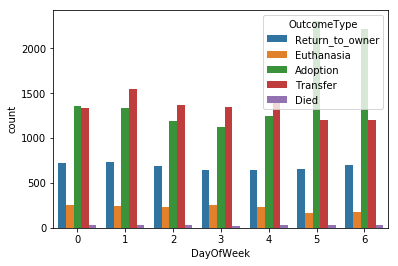

In [341]:
weekdist = pd.DataFrame(data=df[["DateTime", "OutcomeType"]])
weekdist["DayOfWeek"] = weekdist["DateTime"].apply(lambda ts: ts.weekday())

sns.countplot(data=weekdist, x="DayOfWeek", hue="OutcomeType")

In order to capture this information we create a new "IsWeekend" field in our dataset.

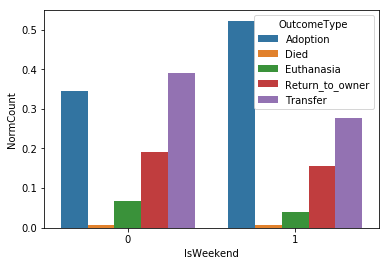

In [342]:
def processWeekend(df):
    df["IsWeekend"] = df["DateTime"].apply(lambda ts: (ts.weekday()>=5))
    df["IsWeekend"] = df["IsWeekend"].astype(int)
#sns.countplot(data=df, x="IsWeekend", hue="OutcomeType")


processWeekend(df)
sns.barplot(data=normalizeCounts(df, "IsWeekend", "OutcomeType", local_agg=True), x="IsWeekend", hue="OutcomeType", y="NormCount")

Does having a name make a difference to the outcome? Yes. Having a name is much more likely to result in adoption and/or return to owner.

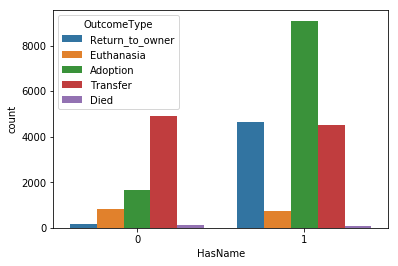

In [343]:
def processName(df):
    df["HasName"] = ~df["Name"].isnull()
    df["HasName"] = df["HasName"].astype(int)


processName(df)

sns.countplot(data=df, x="HasName", hue="OutcomeType")

We also need to simplify the color field. There are too many unique colors. We do this by splitting on "/" or " " and taking only the first word.

In [344]:
df["Color"].unique().size

366

In [345]:
#df["SimpleColor"] = df["Color"].apply(lambda c: c.split("/| ")[0])
def processColor(df):
    df["SimpleColor"] = df["Color"].apply(lambda c: c.lower().split("/")[0].split(" ")[0])


processColor(df)

print df["SimpleColor"].unique().size
df[["Color", "SimpleColor"]].head()


29


,Color,SimpleColor
0,Brown/White,brown
1,Cream Tabby,cream
2,Blue/White,blue
3,Blue Cream,blue
4,Tan,tan


['Return_to_owner' 'Euthanasia' 'Adoption' 'Transfer' 'Died']


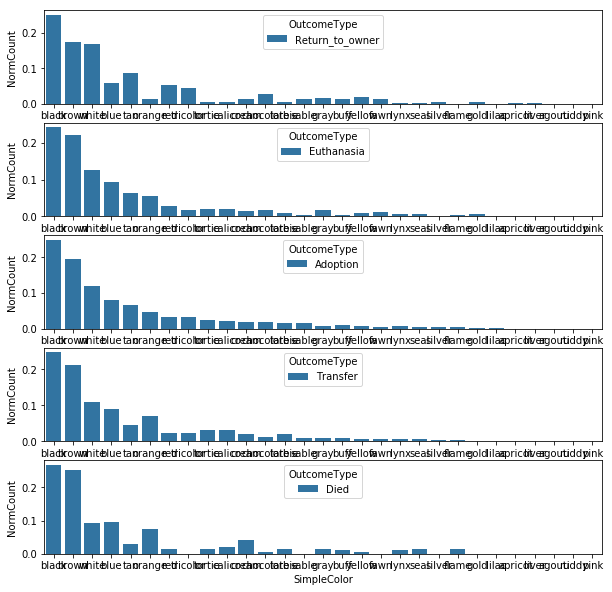

In [346]:
outcomes = df["OutcomeType"].unique()
print outcomes
f, ax1 = plt.subplots(outcomes.size, 1, figsize=(10, 10))

df["SimpleColor"].value_counts().index
for i in range(0,len(outcomes)):
    outcome = outcomes[i]
    sns.barplot(data=normalizeCounts(df.loc[df["OutcomeType"]==outcome,:], x="SimpleColor", sub_x="OutcomeType", local_agg=False), x="SimpleColor", hue="OutcomeType", y="NormCount", order=df["SimpleColor"].value_counts().index, ax=ax1[i])

How balanced or unbalanced are our classes?

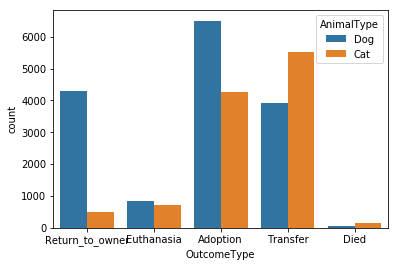

In [347]:
sns.countplot(data=df, x="OutcomeType", hue="AnimalType")

It is clear that there is a severe inbalance in the prediction classes.

The simplest solution is to duplicate records in the minority classes, however experiments with this approach resulted in a worse classifier performance.

Instead we use SMOTE (further down) which empirically gives much better results.

In [348]:
#outcomeCounts = df.pivot_table(index=["OutcomeType"], values=["AnimalID"], aggfunc=len)
#
#maxOutcomeCount = np.max(outcomeCounts.values.ravel())
#
#outcomes = df["OutcomeType"].unique()
#
##newrecords = pd.DataFrame(columns=df.columns)
#
#newrecords = pd.DataFrame.from_items(
#    [(name, pd.Series(data=None, dtype=series.dtype)) for name, series in df.iteritems()])
#
#for outcome in outcomes:
#    outcomeCount = outcomeCounts.loc[outcome].values[0]
#    diff = maxOutcomeCount - outcomeCount
#    
#    if diff > 0:
#        subset = pd.DataFrame(df.loc[df["OutcomeType"]==outcome,:])
#        subset = subset.iloc[np.random.randint(0, subset.index.size, size=diff)]
#        print outcome, ": added ", subset.index.size, " records"
#        newrecords = newrecords.append(subset)
#        
#print "Total records added: ", newrecords.index.size

#df = df.append(newrecords)

#sns.countplot(data=df, x="OutcomeType")

# Machine Learning Model

Prepare a dataset for learning

N.B. We will treat OutcomeType as the dependant variable. OutcomeType is directly inferable from OutcomeSubtype, however this goes contrary to the spirit of the Kaggle challenge and the Kaggle testing set does not include this field among the features, therefore in order for out learning algorithm not to be trivial, we will remove this field.

In [349]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Breed_257,Breed_258,Breed_259,Breed_260,AgeDays,AgeBracket,DaySegment,IsWeekend,HasName,SimpleColor
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,...,0,0,0,0,365.0,juvinile,HR_6,0,1,brown
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,...,0,0,0,0,365.0,juvinile,HR_4,1,1,cream
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,...,0,0,0,0,730.0,adult,HR_4,1,1,blue
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,...,0,0,0,0,21.0,baby,HR_6,0,0,blue
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,...,0,0,0,0,730.0,adult,HR_4,0,0,tan


Select only the fields we need for learning.

In [350]:
#prepared_df = pd.DataFrame(df[["OutcomeType", "AnimalType", "SimpleColor", "Sex", "Neutered", "PureBreed", "Size", "AgeBracket", "DaySegment", "IsWeekend", "HasName"]])

#prepared_df.head()
def reduceOutcome(outcome):
    return outcome in ("Adoption", "Return_to_owner", "Transfer")

# reduce outcome classes to lives/dies
def prepareOutcome(df):
    df["OutcomeTypeReduced"]=prepared_df["OutcomeType"].apply(reduceOutcome)
    
#prepareOutcome(df)

print df.head()
prepared_df = df.copy()
prepared_df = prepared_df.drop(["AnimalID", "Name", "DateTime", "OutcomeSubtype", "SexuponOutcome", "AgeuponOutcome", "Breed", "Color"], axis=1)

print prepared_df.head()


  AnimalID     Name            DateTime      OutcomeType OutcomeSubtype  \
0  A671945  Hambone 2014-02-12 18:22:00  Return_to_owner            NaN   
1  A656520    Emily 2013-10-13 12:44:00       Euthanasia      Suffering   
2  A686464   Pearce 2015-01-31 12:28:00         Adoption         Foster   
3  A683430      NaN 2014-07-11 19:09:00         Transfer        Partner   
4  A667013      NaN 2013-11-15 12:52:00         Transfer        Partner   

  AnimalType SexuponOutcome AgeuponOutcome                        Breed  \
0        Dog  Neutered Male         1 year        Shetland Sheepdog Mix   
1        Cat  Spayed Female         1 year       Domestic Shorthair Mix   
2        Dog  Neutered Male        2 years                 Pit Bull Mix   
3        Cat    Intact Male        3 weeks       Domestic Shorthair Mix   
4        Dog  Neutered Male        2 years  Lhasa Apso/Miniature Poodle   

         Color     ...      Breed_257  Breed_258  Breed_259  Breed_260  \
0  Brown/White     ...  

Pre-process our fields to make them suitable for passing to a machine learning algorithm.

In [351]:
from sklearn import preprocessing
# Need to install sklearn_pandas for DataFrameMapper. This is more flexible than sklearn pipeline
# because it can perform separate operations on different columns of the dataframe.
# pip install sklearn-pandas
from sklearn_pandas import DataFrameMapper

mapper = DataFrameMapper([
    #('OutcomeType', None), #preprocessing.LabelEncoder()),
     ("AnimalType", preprocessing.LabelBinarizer()),
     ("Sex", preprocessing.LabelBinarizer()),
     ("Neutered", preprocessing.LabelBinarizer()),
     ("PureBreed", preprocessing.LabelBinarizer()),
     #("Size", preprocessing.LabelBinarizer()),
     ("AgeBracket", preprocessing.LabelBinarizer()),
     ("DaySegment", preprocessing.LabelBinarizer()),
     ("IsWeekend", preprocessing.LabelBinarizer()),
     ("HasName", preprocessing.LabelBinarizer()),
     ("SimpleColor", None)
], default=None, df_out=True)

labelMapper = DataFrameMapper([
    ("OutcomeType", preprocessing.LabelEncoder())
], df_out=True)



First try fitting a classifier to the dog data


In [352]:
#animal = "Dog"
#prepared_fitted_df = mapper.fit_transform(prepared_df.loc[prepared_df["AnimalType"]==animal,:])
classes_array = labelMapper.fit_transform(prepared_df)

prepared_fitted_df = mapper.fit_transform(prepared_df)

#prepared_fitted_df = prepared_fitted_df.drop(["SimpleColor"], axis=1)
##prepared_fitted_df["Size"] = preprocessing.StandardScaler().fit_transform(prepared_fitted_df[["Size"]])
#prepared_fitted_df["SimpleColor"] = preprocessing.StandardScaler(prepared_fitted_df["SimpleColor"])
print prepared_fitted_df.columns
# Drop redundant columns to avoid the Dummy Variable Trap
#if animal=="Dog":
prepared_fitted_df = prepared_fitted_df.drop(["Sex_unknown",  "AgeBracket_senior", "DaySegment_HR_7", "SimpleColor", "OutcomeType" ], axis=1)
#else:
#    prepared_fitted_df = prepared_fitted_df.drop(["Sex_unknown",  "PureBreed", "AgeBracket_senior", "DaySegment_HR_7", "SimpleColor" ], axis=1)
#prepared_fitted_df.to_csv("prepared_data.csv", index=False)

print prepared_fitted_df.columns

print prepared_fitted_df.head()
print classes_array.head()

prepared_fitted_df.head()
#prepared_fitted_df.to_csv("temp.csv")

Index([u'AnimalType', u'Sex_female', u'Sex_male', u'Sex_unknown', u'Neutered',
       u'PureBreed', u'AgeBracket_adult', u'AgeBracket_baby',
       u'AgeBracket_juvinile', u'AgeBracket_senior',
       ...
       u'Breed_252', u'Breed_253', u'Breed_254', u'Breed_255', u'Breed_256',
       u'Breed_257', u'Breed_258', u'Breed_259', u'Breed_260', u'AgeDays'],
      dtype='object', length=284)
Index([u'AnimalType', u'Sex_female', u'Sex_male', u'Neutered', u'PureBreed',
       u'AgeBracket_adult', u'AgeBracket_baby', u'AgeBracket_juvinile',
       u'DaySegment_HR_0', u'DaySegment_HR_1',
       ...
       u'Breed_252', u'Breed_253', u'Breed_254', u'Breed_255', u'Breed_256',
       u'Breed_257', u'Breed_258', u'Breed_259', u'Breed_260', u'AgeDays'],
      dtype='object', length=279)
  AnimalType Sex_female Sex_male Neutered PureBreed AgeBracket_adult  \
0          1          0        1        1         0                0   
1          0          1        0        1         0                0  

,AnimalType,Sex_female,Sex_male,Neutered,PureBreed,AgeBracket_adult,AgeBracket_baby,AgeBracket_juvinile,DaySegment_HR_0,DaySegment_HR_1,...,Breed_252,Breed_253,Breed_254,Breed_255,Breed_256,Breed_257,Breed_258,Breed_259,Breed_260,AgeDays
0,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,365
1,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,365
2,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,730
3,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,21
4,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,730


Split the prepared dataset into features and classes arrays so that we can pass them to sklearn classifiers.

In [353]:
features_array = prepared_fitted_df.values #prepared_fitted_df.iloc[:,1:].values
#classes_array = prepared_fitted_df[["OutcomeType"]].values
#classes_array = classes_array.astype(int)

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42, kind="borderline2", n_jobs=4)
ss_features, ss_classes = sm.fit_sample(features_array, classes_array)

binarizer = preprocessing.LabelBinarizer()
#ss_classes = binarizer.fit_transform(ss_classes)
X_train, X_test, y_train, y_test = train_test_split(ss_features, ss_classes.ravel(), test_size=0.3, random_state=42)


print features_array.shape
print classes_array.shape
print X_train.shape
print y_train.shape


(26729, 279)
(26729, 1)
(37689, 279)
(37689,)


In [354]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

clf2 = RandomForestClassifier(n_jobs=4, n_estimators=100, bootstrap=False)

#selector = RFECV(svm.SVC(kernel="linear"), cv=3)
selector = RFECV(clf2, cv=3)
selector.fit(X_train, np.ravel(y_train))
print selector.support_
print selector.ranking_
print selector.grid_scores_

#X_train_fitted2 = X_train2#[:,selector.support_]
scores = cross_val_score(clf2, X_train, y_train, cv=3, scoring="f1_weighted")
print scores
print np.average(scores)


[ True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True False  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True False False  True
  True  True  True False  True  True  True False  True  True False  True
  True  True  True False  True  True  True  True  True  True False  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True False  True  True  True False  True  True  True  True False
  True  True  True  True  True  True  True False  True False  True  True
  True False  True  True False  True  True  True  True  True  True False
  True  True  True  True  True  True False  True False  True  True  True
  True  True  True  True False False  True  True  True False  True  True
 False False  True  True False  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  T

In [ ]:
prepared_fitted_df.columns[~selector.support_]

In [355]:
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

clf2.fit(X_train[:,selector.support_], y_train)
proba = clf2.predict_proba(X_test[:,selector.support_])
preds = clf2.predict(X_test[:,selector.support_])
print preds
print X_test.shape
print y_test.shape
print "f1 score=", f1_score(y_test, preds, average="weighted")
print "log loss=", log_loss(y_test, proba)
comp = (preds==y_test)
print proba
print comp
print y_test
print preds
print (float(sum(comp)))/len(comp)



[0 0 1 ..., 0 1 1]
(16153, 279)
(16153,)
f1 score= 0.76620373139
log loss= 2.1266461528
[[ 1.          0.          0.          0.          0.        ]
 [ 0.69        0.          0.01        0.29        0.01      ]
 [ 0.          0.93        0.07        0.          0.        ]
 ..., 
 [ 0.66666667  0.          0.          0.          0.33333333]
 [ 0.          0.86        0.08        0.05        0.01      ]
 [ 0.          0.99        0.01        0.          0.        ]]
[False  True  True ...,  True  True  True]
[3 0 1 ..., 0 1 1]
[0 0 1 ..., 0 1 1]
0.766730638272


In [356]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, clf2.classes_)
print y_test_bin
print proba
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(clf2.n_classes_):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

[[0 0 0 1 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 ..., 
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]]
[[ 1.          0.          0.          0.          0.        ]
 [ 0.69        0.          0.01        0.29        0.01      ]
 [ 0.          0.93        0.07        0.          0.        ]
 ..., 
 [ 0.66666667  0.          0.          0.          0.33333333]
 [ 0.          0.86        0.08        0.05        0.01      ]
 [ 0.          0.99        0.01        0.          0.        ]]


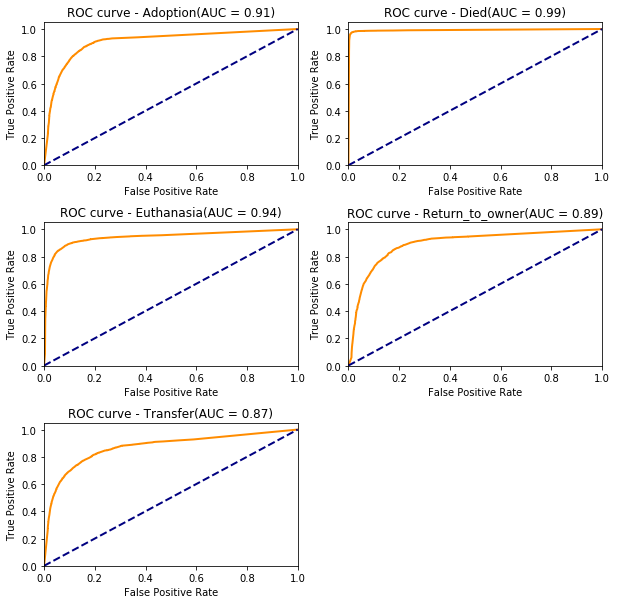

In [357]:
f, plts = plt.subplots(3, 2, figsize=(10, 10))

plts = plts.ravel()
lw = 2

classlabels=labelMapper.features[0][1].inverse_transform(clf2.classes_)

for cls in range(0, len(plts)):#range(0, clf2.n_classes_):
    #plt.subplot(3,2,cls+1)
    if (cls < clf2.n_classes_):
        plts[cls].plot(fpr[cls], tpr[cls], color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[cls])
        plts[cls].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plts[cls].set_xlim([0.0, 1.0])
        plts[cls].set_ylim([0.0, 1.05])
        plts[cls].set_xlabel('False Positive Rate')
        plts[cls].set_ylabel('True Positive Rate')
        plts[cls].set_title('ROC curve - '+classlabels[cls]+"(AUC = " + str(round(roc_auc[cls], 2))+ ")")
        plt.legend(loc="lower right")
    else:
        plts[cls].axis("off")

f.subplots_adjust(hspace=0.4)
plt.show()

In [223]:
testdf = pd.read_csv("test.csv")

splitSex(testdf)
cleanupBreed(testdf)
testdf = processBreed(testdf, breedsTDM)    
processAge(testdf)    
processDate(testdf)
processWeekend(testdf)
processName(testdf)
processColor(testdf)
prepareOutcome(testdf)

prepared_testdf = testdf.copy()
print prepared_testdf.head()
prepared_testdf = prepared_testdf.drop(["ID", "Name", "DateTime", "SexuponOutcome", "AgeuponOutcome", "Breed", "Color"], axis=1)
#prepared_fitted_df = prepared_fitted_df.drop(["Sex_unknown",  "AgeBracket_senior", "DaySegment_HR_7", "SimpleColor", "OutcomeType" ], axis=1)

print prepared_testdf.head()

prepared_fitted_testdf = mapper.fit_transform(prepared_testdf)

#prepared_fitted_df = prepared_fitted_df.drop(["SimpleColor"], axis=1)
##prepared_fitted_df["Size"] = preprocessing.StandardScaler().fit_transform(prepared_fitted_df[["Size"]])
#prepared_fitted_df["SimpleColor"] = preprocessing.StandardScaler(prepared_fitted_df["SimpleColor"])
print prepared_fitted_testdf.columns
# Drop redundant columns to avoid the Dummy Variable Trap
#if animal=="Dog":
prepared_fitted_testdf = prepared_fitted_testdf.drop(["Sex_unknown",  "AgeBracket_senior", "DaySegment_HR_7", "SimpleColor" ], axis=1)
prepared_fitted_testdf.head()

   ID      Name            DateTime AnimalType SexuponOutcome AgeuponOutcome  \
0   1    Summer 2015-10-12 12:15:00        Dog  Intact Female      10 months   
1   2  Cheyenne 2014-07-26 17:59:00        Dog  Spayed Female        2 years   
2   3       Gus 2016-01-13 12:20:00        Cat  Neutered Male         1 year   
3   4     Pongo 2013-12-28 18:12:00        Dog    Intact Male       4 months   
4   5   Skooter 2015-09-24 17:59:00        Dog  Neutered Male        2 years   

                            Breed        Color     Sex  Neutered  \
0          Labrador Retriever Mix    Red/White  female         0   
1  German Shepherd/Siberian Husky    Black/Tan  female         1   
2          Domestic Shorthair Mix  Brown Tabby    male         1   
3               Collie Smooth Mix     Tricolor    male         0   
4            Miniature Poodle Mix        White    male         1   

          ...          Breed_259  Breed_260  Breed_261  AgeDays  AgeBracket  \
0         ...                  

,AnimalType,Sex_female,Sex_male,Neutered,PureBreed,AgeBracket_adult,AgeBracket_baby,AgeBracket_juvinile,DaySegment_HR_0,DaySegment_HR_1,...,Breed_254,Breed_255,Breed_256,Breed_257,Breed_258,Breed_259,Breed_260,Breed_261,AgeDays,OutcomeTypeReduced
0,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,300,True
1,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,730,False
2,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,365,True
3,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,120,True
4,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,730,True


In [227]:
#clf2.fit(ss_features[:,selector.support_], ss_classes)

X_kaggle_test = prepared_fitted_testdf.values
print prepared_fitted_testdf.head()
print prepared_fitted_df.head()
preds = clf2.predict(X_kaggle_test[:,selector.support_])
probs = clf2.predict_proba(X_kaggle_test[:,selector.support_])
print clf2.classes_
print labelMapper.features[0][1].inverse_transform(clf2.classes_)
results = np.concatenate((testdf[["ID"]].values, probs), axis=1)
resultsdf = pd.DataFrame(results, columns=["ID","Adoption","Died","Euthanasia","Return_to_owner","Transfer"])
resultsdf["ID"] = resultsdf["ID"].astype(int)
resultsdf.to_csv("results3csv", index=False)
resultsdf

  AnimalType Sex_female Sex_male Neutered PureBreed AgeBracket_adult  \
0          1          1        0        0         0                0   
1          1          1        0        1         0                1   
2          0          0        1        1         0                0   
3          1          0        1        0         0                0   
4          1          0        1        1         0                1   

  AgeBracket_baby AgeBracket_juvinile DaySegment_HR_0 DaySegment_HR_1  \
0               0                   1               0               0   
1               0                   0               0               0   
2               0                   1               0               0   
3               0                   1               0               0   
4               0                   0               0               0   

         ...         Breed_254 Breed_255 Breed_256 Breed_257 Breed_258  \
0        ...                 0         0         0    

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0.070000,0.00,0.00,0.145000,0.785000
1,2,0.003333,0.16,0.77,0.043333,0.023333
2,3,0.218637,0.00,0.01,0.477011,0.294352
3,4,0.270000,0.00,0.05,0.220000,0.460000
4,5,0.299000,0.00,0.00,0.323000,0.378000
5,6,0.394000,0.00,0.02,0.526000,0.060000
6,7,0.020000,0.00,0.04,0.300000,0.640000
7,8,1.000000,0.00,0.00,0.000000,0.000000
8,9,0.820000,0.00,0.00,0.080000,0.100000
9,10,0.513333,0.00,0.01,0.333333,0.143333


# ANN


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score#accuracy_score

C_range = np.arange(0, 1, 0.1)

cv_score=[]
test_score=[]

for C in C_range:
    print "Testing for C=" + str(C)
    clf = MLPClassifier(solver='adam', activation="relu", max_iter=2000, verbose=True, tol=0.0001, alpha=C, hidden_layer_sizes=(prepared_fitted_df.columns.size*5,prepared_fitted_df.columns.size*2))
    clf = MLPRegressor(solver='adam', activation="relu", max_iter=2000, verbose=True, tol=0.0001, alpha=C, hidden_layer_sizes=(prepared_fitted_df.columns.size*5,prepared_fitted_df.columns.size*5))

    scores = cross_val_score(clf, X_train, y_train, cv=3)
    cv_score.append(np.average(scores))
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    test_score.append(r2_score(y_test, preds))
    
#clf = OneVsRestClassifier(clf)
#clf.fit(X_train_fitted, y_train)                         
#selector = RFECV(clf, cv=3)
#selector.fit(X_train, np.ravel(y_train))
#print selector.support_
#print selector.ranking_

#X_train_fitted = X_train[:,selector.support_]
#scores = cross_val_score(clf, X_train, y_train, cv=3)
#print scores
#print np.average(scores)

In [ ]:
import matplotlib.pyplot as plt
print cv_score
plt.plot(C_range, cv_score, "-b", C_range, test_score, "-r")
print cv_score
#print test_score
#print C_range



In [ ]:
from sklearn.metrics import accuracy_score

#clf.fit(X_train, y_train)
clf.fit(ss_features, ss_classes)


In [ ]:
X_test = prepared_fitted_testdf.values

preds = clf.predict(X_test)

preds.shape

print preds

norm_preds = [ [ (preds[i,j]-min(preds[i,:]))/(max(preds[i,:])-min(preds[i,:])) for j in range(0, preds.shape[1])] for i in range(0,preds.shape[0])]

print norm_preds

#print lb.classes_

In [ ]:
labelMapper.transformed_names_
print labelMapper.features[0][1].classes_

results = np.concatenate((testdf[["ID"]].values, norm_preds), axis=1)
resultsdf = pd.DataFrame(results, columns=["ID","Adoption","Died","Euthanasia","Return_to_owner","Transfer"])
resultsdf["ID"] = resultsdf["ID"].astype(int)
resultsdf.to_csv("results.csv", index=False)
resultsdf

In [ ]:
mapper.transformed_names_
print mapper.features[0][1].classes_

norm_preds = [ [ int((preds[i,j]-min(preds[i,:]))/(max(preds[i,:])-min(preds[i,:]))) for j in range(0, preds.shape[1])] for i in range(0,preds.shape[0])]

print norm_preds

score = [ (norm_preds[i][0]==y_test[i][0]) and (norm_preds[i][1]==y_test[i][1]) and (norm_preds[i][2]==y_test[i][2]) and (norm_preds[i][3]==y_test[i][3]) and (norm_preds[i][4]==y_test[i][4]) for i in range(0, y_test.shape[0])]

float(sum(score))/len(score)

In [ ]:
print preds
print y_test
score = preds==y_test.ravel()
print score
print float(sum(score))/len(score)